Logistic Regression F1 Score on Training Data: 0.9304
Logistic Regression F1 Score on Test Data: 0.9376
Random Forest F1 Score on Training Data: 0.9793
Random Forest F1 Score on Test Data: 0.9366
SVC F1 Score on Training Data: 0.9542
SVC F1 Score on Test Data: 0.9441
XGBoost F1 Score on Training Data: 0.9476
XGBoost F1 Score on Test Data: 0.9378
Voting Classifier F1 Score on Training Data: 0.9555
Voting Classifier F1 Score on Test Data: 0.9421


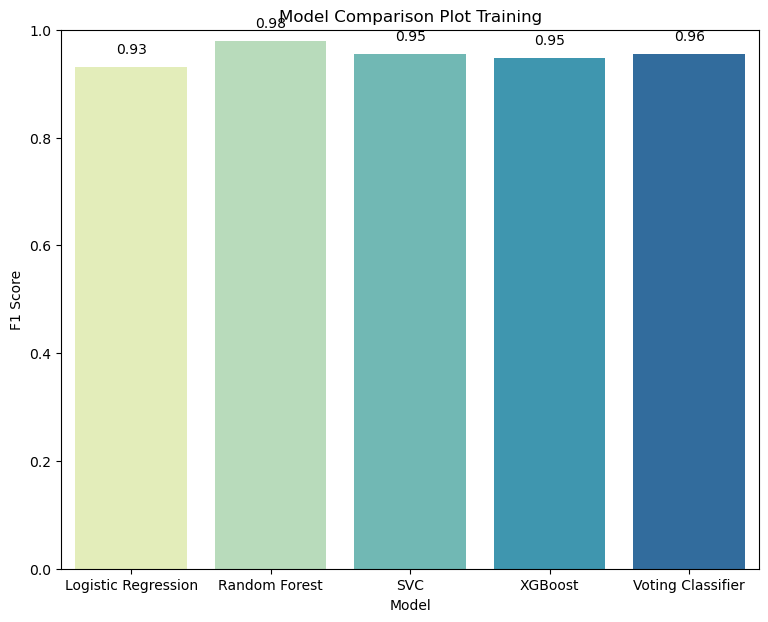

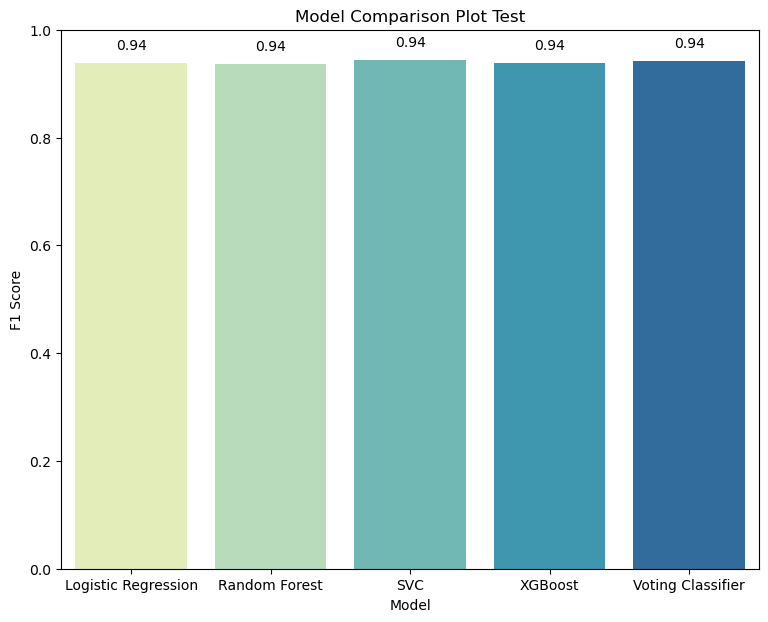

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df_student = pd.read_csv('data/prep_data.csv')  # Adjust the path as necessary

# Drop 'Nationality' and 'International' columns if needed
df_student = df_student.drop(columns=['Nationality', 'International'])

# Remove 'Enrolled' from the Target
df_student = df_student[df_student['Target'] != 'Enrolled']

# Encode the 'Target' variable
label_encoder = LabelEncoder()
df_student['Target'] = label_encoder.fit_transform(df_student['Target'])

# Define features and target
X = df_student.drop(columns=['Target'])  # Replace 'Target' with your target column
y = df_student['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Create pipelines for different models
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=2000, random_state=42))
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier(random_state=42))
])

pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=42))
])

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

# Define the hyperparameters to tune for each model
param_grid_lr = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'logistic__solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga']
}

param_grid_rf = {
    'random_forest__n_estimators': [50, 100],  # Number of trees
    'random_forest__max_depth': [None, 10, 20],
    'random_forest__min_samples_split': [2, 5],
    'random_forest__min_samples_leaf': [1, 2],
}

param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [1, 0.1, 0.01],
    'svc__kernel': ['rbf']
}

param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 1]
}

# Perform grid search with cross-validation for each model
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
best_model_lr = grid_search_lr.best_estimator_

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_estimator_

grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svc.fit(X_train, y_train)
best_model_svc = grid_search_svc.best_estimator_

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_model_xgb = grid_search_xgb.best_estimator_

# Define the VotingClassifier with all models
voting_clf = VotingClassifier(estimators=[
    ('lr', best_model_lr),
    ('rf', best_model_rf),
    ('svc', best_model_svc),
    ('xgb', best_model_xgb)
], voting='soft')

voting_clf.fit(X_train, y_train)

# Evaluate the models on training and test data
models = {
    'Logistic Regression': best_model_lr,
    'Random Forest': best_model_rf,
    'SVC': best_model_svc,
    'XGBoost': best_model_xgb,
    'Voting Classifier': voting_clf
}

f1_scores_train = {}
f1_scores_test = {}

for model_name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    f1_scores_train[model_name] = f1_score(y_train, y_train_pred)
    f1_scores_test[model_name] = f1_score(y_test, y_test_pred)
    print(f"{model_name} F1 Score on Training Data: {f1_scores_train[model_name]:.4f}")
    print(f"{model_name} F1 Score on Test Data: {f1_scores_test[model_name]:.4f}")

# Visualization of model comparison
def barplot_models(model_scores, title):
    model_names = list(model_scores.keys())
    f1_scores = list(model_scores.values())
    plt.figure(figsize=(9, 7))
    sns.set_palette("YlGnBu")
    bars = sns.barplot(x=model_names, y=f1_scores)
    plt.title(title)
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    for bar, f1_score in zip(bars.patches, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{f1_score:.2f}", ha="center", va="bottom")
    plt.show()

barplot_models(model_scores=f1_scores_train, title="Model Comparison Plot Training")
barplot_models(model_scores=f1_scores_test, title="Model Comparison Plot Test")


In [8]:
from sklearn.ensemble import StackingClassifier

# Define base learners
base_learners = [
    ('lr', best_model_lr),
    ('rf', best_model_rf),
    ('svc', best_model_svc),
    ('xgb', best_model_xgb)
]

# Define meta-learner
meta_learner = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=3)

# Fit stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the stacking classifier
y_train_pred_stacking = stacking_clf.predict(X_train)
y_test_pred_stacking = stacking_clf.predict(X_test)

# Calculate F1 scores
f1_score_train_stacking = f1_score(y_train, y_train_pred_stacking)
f1_score_test_stacking = f1_score(y_test, y_test_pred_stacking)

print(f"Stacking Classifier F1 Score on Training Data: {f1_score_train_stacking:.4f}")
print(f"Stacking Classifier F1 Score on Test Data: {f1_score_test_stacking:.4f}")


Stacking Classifier F1 Score on Training Data: 0.9652
Stacking Classifier F1 Score on Test Data: 0.9288


In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Create an AdaBoost classifier
boosting_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)

# Fit boosting classifier
boosting_clf.fit(X_train, y_train)

# Evaluate the boosting classifier
y_train_pred_boosting = boosting_clf.predict(X_train)
y_test_pred_boosting = boosting_clf.predict(X_test)

# Calculate F1 scores
f1_score_train_boosting = f1_score(y_train, y_train_pred_boosting)
f1_score_test_boosting = f1_score(y_test, y_test_pred_boosting)

print(f"Boosting Classifier F1 Score on Training Data: {f1_score_train_boosting:.4f}")
print(f"Boosting Classifier F1 Score on Test Data: {f1_score_test_boosting:.4f}")


Boosting Classifier F1 Score on Training Data: 0.9340
Boosting Classifier F1 Score on Test Data: 0.9179
